In [17]:
import os
import git
from pathlib import Path

ROOT_DIR =  Path(git.Repo('.', search_parent_directories=True).working_tree_dir)
SAVE_FIGS = False

In [18]:
os.chdir(os.path.join(ROOT_DIR, "utilities"))
from testing import * # If MATLAB is not installed, open utilities and set to False
from plotting import *
from reporting import *
plots_path = os.path.join(ROOT_DIR, "publication", "paper", "CSVs")
save_path_with_hull = Path(os.path.join(ROOT_DIR, 'publication', 'paper', 'CSVs', 'final_results_with_hull.pickle'))
main_df = pd.read_pickle(save_path_with_hull)
RERUN = False
np.random.seed(0)

## Aggregate Stats

In [19]:
main_df['kstest_stat_overall_best'] = np.minimum.reduce([main_df['kstest_stat_best'], main_df['kstest_stat_gaussian'], main_df['kstest_stat_laplace'], main_df['kstest_stat_t']])
temp = main_df[main_df['beat_all_priors'] == 0].copy()
n = len(main_df)

c1, c0 = main_df['beat_all_priors'].value_counts()
print("% Beats All Other Priors:", c1 / n * 100, ",", c1, "/", n)
trivial_fails, _, _, _, _ = temp['failure_category'].value_counts()
print("Given that OurPrior is Worse, % Trivial Failures:", trivial_fails / n * 100, ",", trivial_fails, "/", n)

temp = temp[temp['failure_category'] != 'trivial_failure']
print("Given that OurPrior is Worse, Maximum difference between OurPrior and Best:", max(np.abs(temp['kstest_stat_overall_best'] - temp['kstest_stat_best'])))

% Beats All Other Priors: 91.34199134199135 , 1055 / 1155
Given that OurPrior is Worse, % Trivial Failures: 7.705627705627706 , 89 / 1155
Given that OurPrior is Worse, Maximum difference between OurPrior and Best: 0.0035451361585638


In [20]:
practical, trivial, actual, border, interesting = main_df['failure_category'].sort_values().value_counts()
print("Actually Passing:", (practical) / n)
print("Practically Passing:", (practical) / n)
print("Passing Overall:", (practical + trivial) / n)
print("Passing Overall (borderline):", (practical + trivial + border) / n)


Actually Passing: 0.541991341991342
Practically Passing: 0.541991341991342
Passing Overall: 0.7731601731601732
Passing Overall (borderline): 0.8303030303030303


In [21]:
main_df = main_df[main_df['total_samples'].iloc[:, 0] > 100]
main_df['best_beta'] = (main_df['best_eta'] + 1.5)/main_df['best_r']
main_df = main_df[(main_df['dataset'] != 'standardTesting')]

In [22]:
name_mapping = {'syntheticMRI3Dfull': 'syntheticMRI3D',
                'syntheticMRI2Daxial': 'syntheticMRI2D (axial)',
                'syntheticMRI2Dsagittal': 'syntheticMRI2D (sagittal)',
                'syntheticMRI2Dcoronal': 'syntheticMRI2D (coronal)',
                'spaceNetfull': 'spaceNet',
                'cocoindoor': 'coco (indoor)',
                'cocooutdoor': 'coco (outdoor)',
                'pastisfull': 'pastis',
                'segmentAnythingfull': 'segmentAnything',
                'agriVisionfull': 'agriVision',
                'standardTestingfull': 'standardTesting'}

main_df['dataset'] = (main_df['dataset'] + main_df['subset']).replace(name_mapping)

In [23]:
main_df['hull_eta_lower'] = main_df['hull_beta_lower']
main_df["n_pval_0.05"]

0         33750.0
1         74038.0
2         70875.0
3        156619.0
4        318937.0
          ...    
1150      42786.0
1151    1502428.0
1152      90020.0
1153     222910.0
1154     263374.0
Name: n_pval_0.05, Length: 1058, dtype: float64

In [64]:
granularity1 = ['transform', 'dataset_type', 'dataset']
final_cols =  ['median_total_samples', 'kstest_stat_best', 'statistically_pass', 'practically_pass', 'intersect_roi']  #, 'uses_practical_threshold', 'intersect_roi', 'hull_r_lower_ci95', 'hull_r_upper_ci95', 'hull_beta_lower_ci95', 'hull_beta_upper_ci95']
temp = main_df.copy()# & (main_df['transform'] != 'learned')]
temp['orientation'] = temp.apply(
    lambda row: 'fourier' if row['transform'] == 'fourier' 
    else ('learned' if row['transform'] == 'learned' else row['orientation']),
    axis=1
)
temp['practically_pass'] = (temp['failure_category'] == 'practically_pass')
temp['statistically_pass'] = (temp['failure_category'] == 'actually_pass')
temp['borderline'] = (temp['failure_category'] == 'borderline')
temp["interesting_failure"] = (temp['failure_category'] == 'interesting_failure')
temp["trivial_failure"] = (temp['failure_category'] == 'trivial_failure')

summary_df = (temp.groupby(granularity1)[['statistically_pass','practically_pass', "borderline", 'interesting_failure', 'trivial_failure', 'intersect_roi']].mean() * 100).round(1)#.sort_values('dataset')
summary_df["kstest_stat_best"] = temp.groupby(granularity1)['kstest_stat_best'].median(numeric_only=True)
# summary_df["kstest_stat_best_std"] = temp.groupby(granularity1)['kstest_stat_best'].std(numeric_only=True)
# summary_df["kstest_stat_best"] = (summary_df["kstest_stat_best_median"].round(4).astype(str) + " (" + (2*summary_df["kstest_stat_best_std"]).round(4).astype(str) + ")")
summary_df["median_total_samples"] = temp.groupby(granularity1)['total_samples'].median().astype(float).iloc[:,0].apply(lambda x : np.format_float_scientific(x, exp_digits=1, precision=1))
summary_df["uses_practical_threshold"] = temp.groupby(granularity1)['uses_practical_threshold'].mean()

for col in ['hull_r_lower', 'hull_r_upper', 'hull_beta_lower', 'hull_beta_upper']:
    summary_df[f'{col}_ci95'] = temp.groupby(granularity1)[col].apply(lambda x:  [np.round(x, 2) for x in np.percentile(x, [2.5, 97.5])])
summary_df = summary_df[final_cols].round(3) #.reset_index()#.drop('dataset', axis=1)
summary_df

median_total_samples  \
transform dataset_type   dataset                                          
fourier   remote sensing agriVision                              2.6e+6   
                         pastis                                  2.6e+5   
                         spaceNet                                1.8e+6   
learned   natural        coco (indoor)                            2.e+8   
                         coco (outdoor)                           2.e+8   
                         segmentAnything                         7.9e+8   
          remote sensing agriVision                              7.9e+8   
                         pastis                                  4.9e+5   
                         spaceNet                                4.8e+8   
wavelet   medical        syntheticMRI2D (axial)                  4.2e+6   
                         syntheticMRI2D (coronal)                3.7e+6   
                         syntheticMRI2D (sagittal)               2.4e+6   
                         syntheticMRI3D                          1.6e+6   
          natural        coco (indoor)                           2.6e+5   
                         coco (outdoor)                          3.9e+5   
                         segmentAnything                         1.8e+6   
          remote sensing agriVision                              1.7e+6   
                         pastis                                  1.5e+5   
                         spaceNet                                1.6e+6   

                                                    kstest_stat_best  \
transform dataset_type   dataset                                       
fourier   remote sensing agriVision                            0.005   
                         pastis                                0.002   
                         spaceNet                              0.005   
learned   natural        coco (indoor)                         0.010   
                         coco (outdoor)                        0.009   
                         segmentAnything                       0.005   
          remote sensing agriVision                            0.005   
                         pastis                                0.006   
                         spaceNet                              0.012   
wavelet   medical        syntheticMRI2D (axial)                0.007   
                         syntheticMRI2D (coronal)              0.004   
                         syntheticMRI2D (sagittal)             0.005   
                         syntheticMRI3D                        0.005   
          natural        coco (indoor)                         0.013   
                         coco (outdoor)                        0.011   
                         segmentAnything                       0.004   
          remote sensing agriVision                            0.005   
                         pastis                                0.005   
                         spaceNet                              0.012   

                                                    statistically_pass  \
transform dataset_type   dataset                                         
fourier   remote sensing agriVision                                2.3   
                         pastis                                   90.9   
                         spaceNet                                  0.0   
learned   natural        coco (indoor)                             0.0   
                         coco (outdoor)                            0.0   
                         segmentAnything                           0.0   
          remote sensing agriVision                                0.0   
                         pastis                                    0.0   
                         spaceNet                                  0.0   
wavelet   medical        syntheticMRI2D (axial)                    0.0   
                         syntheticMRI2D (coronal)                  9.5   


In [65]:
granularity2 = ['transform', 'dataset_type']
temp = main_df.copy()# & (main_df['transform'] != 'learned')]
temp['orientation'] = temp.apply(
    lambda row: 'fourier' if row['transform'] == 'fourier' 
    else ('learned' if row['transform'] == 'learned' else row['orientation']),
    axis=1
)
temp['practically_pass'] = (temp['failure_category'] == 'practically_pass')
temp['statistically_pass'] = (temp['failure_category'] == 'actually_pass')
temp['borderline'] = (temp['failure_category'] == 'borderline')
temp["interesting_failure"] = (temp['failure_category'] == 'interesting_failure')
temp["trivial_failure"] = (temp['failure_category'] == 'trivial_failure')
summary_df2 = (temp.groupby(granularity2)[['statistically_pass','practically_pass', "borderline", 'interesting_failure', 'trivial_failure', 'intersect_roi']].mean() * 100).round(1)#.sort_values('dataset')
summary_df2["kstest_stat_best"] = temp.groupby(granularity2)['kstest_stat_best'].median(numeric_only=True)
summary_df2["kstest_stat_best_std"] = temp.groupby(granularity2)['kstest_stat_best'].std(numeric_only=True)
summary_df2["median_total_samples"] = temp.groupby(granularity2)['total_samples'].median().astype(float).iloc[:,0].apply(lambda x : np.format_float_scientific(x, 1))
summary_df2["uses_practical_threshold"] = temp.groupby(granularity2)['uses_practical_threshold'].mean()

for col in ['hull_r_lower', 'hull_r_upper', 'hull_beta_lower', 'hull_beta_upper']:
    summary_df2[f'{col}_ci95'] = temp.groupby(granularity2)[col].apply(lambda x:  [np.round(x, 1) for x in np.percentile(x, [2.5, 97.5])])


summary_df2 = summary_df2[final_cols].round(3) #.reset_index()#.drop('dataset', axis=1)
summary_df2 = summary_df2.assign(dataset='z_aggregate').reset_index().set_index(granularity1)
summary_df_final = pd.concat([summary_df, summary_df2]).reset_index()

summary_df_final['transform'] = pd.Categorical(summary_df_final['transform'], categories=['fourier', 'wavelet', 'learned'], ordered=True)
summary_df_final = summary_df_final.sort_values(['transform', 'dataset_type', 'dataset'])
summary_df_final.to_csv(os.path.join(plots_path, 'results_table.csv'))

In [66]:
summary_df_final

,transform,dataset_type,dataset,median_total_samples,kstest_stat_best,statistically_pass,practically_pass,intersect_roi
0,fourier,remote sensing,agriVision,2.6e+6,0.005,2.3,93.2,70.5
1,fourier,remote sensing,pastis,2.6e+5,0.002,90.9,9.1,100.0
2,fourier,remote sensing,spaceNet,1.8e+6,0.005,0.0,100.0,50.0
19,fourier,remote sensing,z_aggregate,5.5e+05,0.003,34.2,64.2,75.8
9,wavelet,medical,syntheticMRI2D (axial),4.2e+6,0.007,0.0,76.2,33.3
10,wavelet,medical,syntheticMRI2D (coronal),3.7e+6,0.004,9.5,71.4,57.1
11,wavelet,medical,syntheticMRI2D (sagittal),2.4e+6,0.005,0.0,81.0,76.2
12,wavelet,medical,syntheticMRI3D,1.6e+6,0.005,7.1,61.9,66.7
22,wavelet,medical,z_aggregate,2.9e+06,0.005,4.8,70.5,60.0
13,wavelet,natural,coco (indoor),2.6e+5,0.013,25.0,25.0,37.5


In [27]:
temp[['statistically_pass', 'practically_pass', 'intersect_roi', 'hull_area', 'total_samples']].mean(), main_df[['total_samples']].median()


(statistically_pass    0.000000e+00
 practically_pass      5.718336e-01
 intersect_roi         5.245747e-01
 hull_area             4.366624e+01
 total_samples         1.610691e+08
 total_samples         1.610691e+08
 dtype: float64,
 total_samples    6512640.0
 total_samples    6512640.0
 dtype: float64)

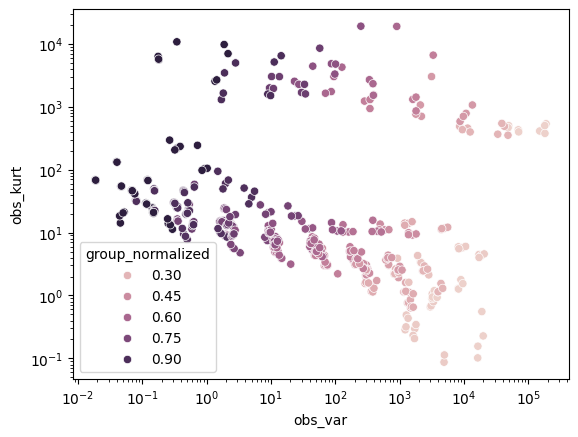

In [28]:
main_df['group_normalized'] = main_df.groupby(['dataset', 'channel', 'orientation'])['group'].transform(lambda x: x / x.max())
main_df['var_normalized'] = main_df.groupby(['dataset', 'channel', 'orientation'])['obs_var'].transform(lambda x: x / x.max())
main_df['kurt_normalized'] = main_df.groupby(['dataset', 'channel', 'orientation'])['obs_kurt'].transform(lambda x: x / x.max())
sns.scatterplot(data=main_df[main_df['transform'] != 'learned'], x='obs_var', y='obs_kurt', hue='group_normalized')
plt.xscale('log')
plt.yscale('log')


In [29]:
[stats.kstwo(n=10**i).isf(0.05) for i in range(3, 10)]

[0.042776500461245,
 0.013564202793681023,
 0.004293014618329405,
 0.0013579318555276864,
 0.0004294518283725128,
 0.00013580819714844155,
 4.294668320280901e-05]

In [30]:
main_df['n_pval_0.05']

0         33750.0
1         74038.0
2         70875.0
3        156619.0
4        318937.0
          ...    
1150      42786.0
1151    1502428.0
1152      90020.0
1153     222910.0
1154     263374.0
Name: n_pval_0.05, Length: 1058, dtype: float64

<Axes: >

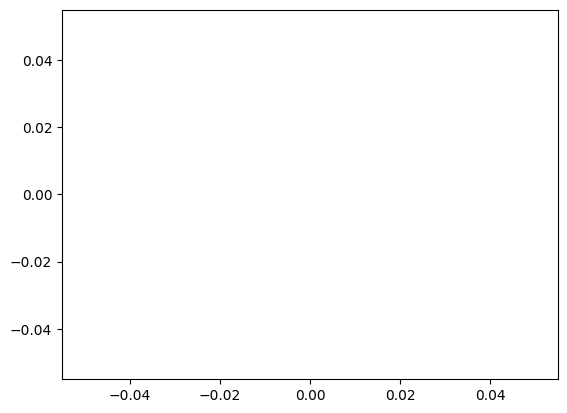

In [31]:
sns.histplot()